# 1. Import Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import warnings
warnings.filterwarnings('ignore')

# 2. Data Loading

In [87]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the data
df = pd.read_csv("raw_data.csv")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3. Data Cleaning and Preprocessing

In [88]:
# Data Cleaning and Preprocessing
def clean_text(text):
    """Cleans the text by removing URLs, mentions, and special characters."""
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\S+", "", text)  # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters (keeping spaces)
    text = text.lower()  # Convert to lowercase
    return text

df['Text'] = df['Text'].astype(str) # Ensure text column is string type
df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Additional text preprocessing for advanced analysis
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [ps.stem(word) for word in filtered_tokens]
    return ' '.join(stemmed_tokens)

df['Processed_Text'] = df['Cleaned_Text'].apply(preprocess_text)

# 4. Sentiment Analysis

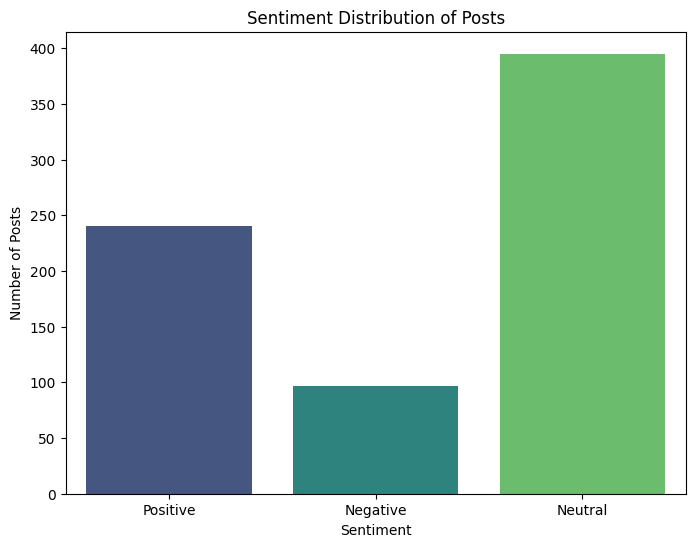

In [89]:
# Sentiment Analysis
def get_sentiment(text):
    """Performs sentiment analysis using TextBlob."""
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns polarity score (-1 to 1)

df['Sentiment_Score'] = df['Cleaned_Text'].apply(get_sentiment)

def categorize_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['Calculated_Sentiment'] = df['Sentiment_Score'].apply(categorize_sentiment)

# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Calculated_Sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution of Posts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()

# 5. Platform Analysis


Average Sentiment Score by Platform:
 Platform
Twitter       0.123020
Instagram     0.107448
Facebook      0.082204
Twitter       0.053177
Name: Sentiment_Score, dtype: float64


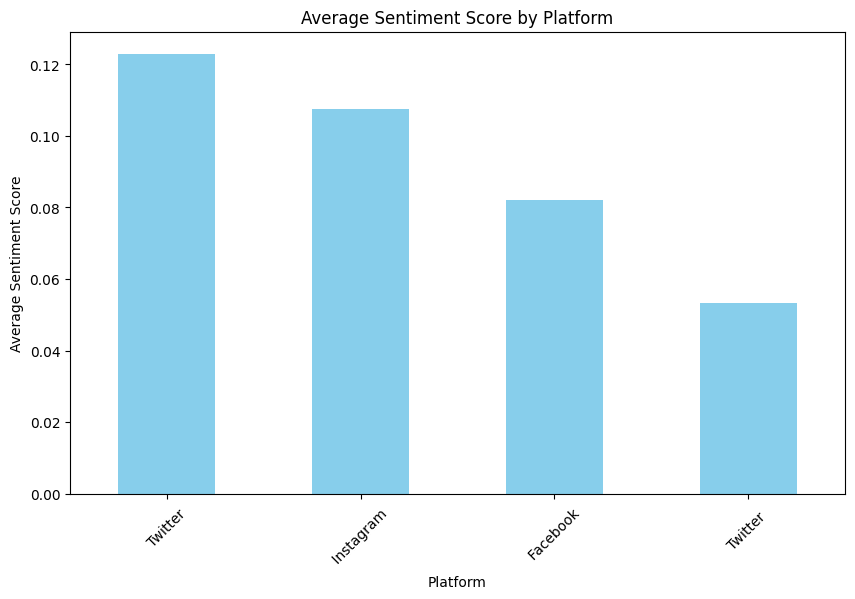

In [90]:
# Platform-Specific Analysis
platform_sentiment = df.groupby('Platform')['Sentiment_Score'].mean().sort_values(ascending=False)
print("\nAverage Sentiment Score by Platform:\n", platform_sentiment)

# Visualization: Platform Sentiment Comparison
plt.figure(figsize=(10, 6))
platform_sentiment.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

# 6. Hashtag Analysis


Top 20 Trending Hashtags:
 [('#Serenity', 15), ('#Gratitude', 13), ('#Excitement', 13), ('#Despair', 11), ('#Nostalgia', 11), ('#Contentment', 10), ('#Curiosity', 10), ('#Awe', 9), ('#Grief', 9), ('#Loneliness', 9), ('#Hopeful', 9), ('#Enthusiasm', 8), ('#Joy', 8), ('#Acceptance', 8), ('#Confusion', 8), ('#Inspiration', 7), ('#Elation', 7), ('#Euphoria', 7), ('#Determination', 7), ('#Reflection', 6)]


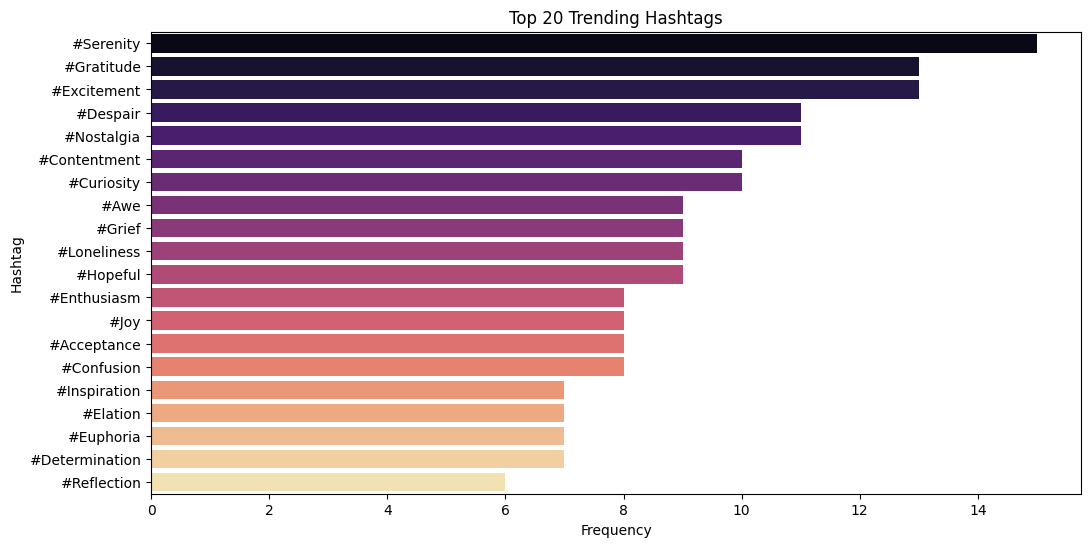

In [91]:
# Trending Topics (Hashtags) Analysis
def extract_hashtags(text):
    """Extracts hashtags from a text string."""
    if isinstance(text, str):  # Check if text is a string to avoid errors
        return re.findall(r"#\w+", text)
    else:
        return []  # Return an empty list if the input is not a string

df['Hashtags'] = df['Hashtags'].astype(str) # Ensure hashtags column is string
df['Extracted_Hashtags'] = df['Hashtags'].apply(extract_hashtags)

all_hashtags = []
for hashtags in df['Extracted_Hashtags']:
    all_hashtags.extend(hashtags)

hashtag_counts = Counter(all_hashtags)
top_20_hashtags = hashtag_counts.most_common(20)
print("\nTop 20 Trending Hashtags:\n", top_20_hashtags)

# Visualization: Top 20 Trending Hashtags
plt.figure(figsize=(12, 6))
hashtags, counts = zip(*top_20_hashtags)
sns.barplot(x=list(counts), y=list(hashtags), palette='magma')
plt.title('Top 20 Trending Hashtags')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.show()

# 7. Time Series Analysis


Monthly Average Sentiment:
 Timestamp
2010-05-31    0.100000
2010-06-30         NaN
2010-07-31         NaN
2010-08-31    0.000000
2010-09-30         NaN
                ...   
2023-06-30    0.159071
2023-07-31    0.075613
2023-08-31    0.192550
2023-09-30   -0.112464
2023-10-31    0.198040
Freq: ME, Name: Sentiment_Score, Length: 162, dtype: float64


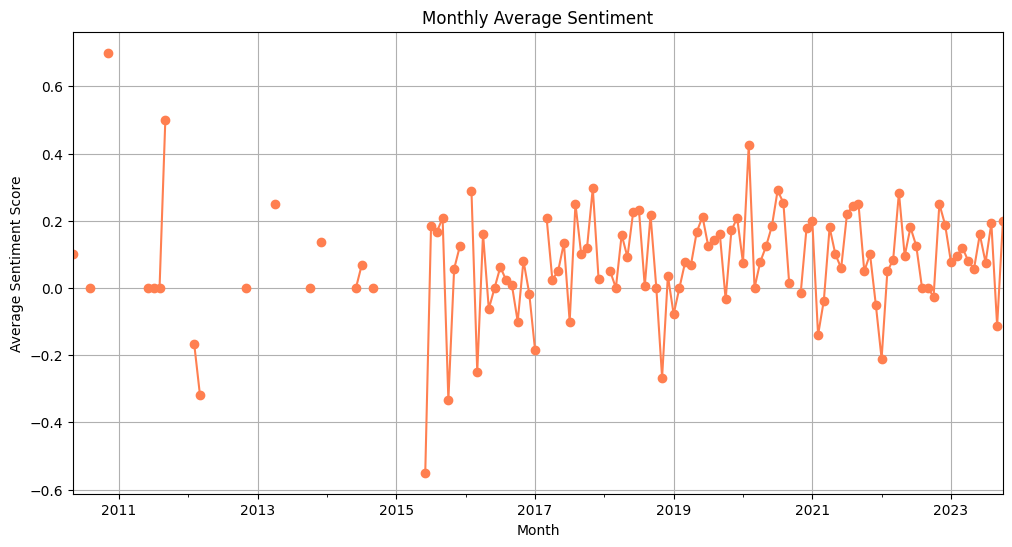

In [92]:
# Time Series Analysis
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

monthly_sentiment = df.resample('M')['Sentiment_Score'].mean()
print("\nMonthly Average Sentiment:\n", monthly_sentiment)

# Visualization: Time Series Plot of Monthly Sentiment
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(marker='o', linestyle='-', color='coral')
plt.title('Monthly Average Sentiment')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

# 8. Advanced Analysis - Topic Modeling

In [93]:
# Topic Modeling with LDA
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['Processed_Text'])

lda = LDA(n_components=5, random_state=42)
lda.fit(tfidf)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d:" % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("\nTop Words per Topic:")
print_top_words(lda, tfidf_vectorizer.get_feature_names_out(), 10)


Top Words per Topic:
Topic #0:seren accept lost whisper explor life mind thought laughter embrac
Topic #1:learn danc natur new silent project enthusiasm journey ride trust
Topic #2:day sens achiev challeng beauti feel surpris celebr garden bloom
Topic #3:emot day bitter joy like new air perfect overflow love
Topic #4:book new weekend excit hope person dream symphoni night solitud


# 9. Advanced Analysis - User Engagement


Top Users by Engagement:
                    Retweets  Likes
User                              
WinterWarmth           85.0  170.0
CosmosExplorer         80.0  160.0
CarnivalDreamer        72.0  144.0
CulinaryExplorer       70.0  140.0
MusicHarmonist         70.0  140.0
PeakConqueror          69.0  138.0
EchoedLaughter         65.0  130.0
RainNurturer           63.0  126.0
GrowthSeeker           60.0  120.0
DanceEnthusiast        56.0  110.0


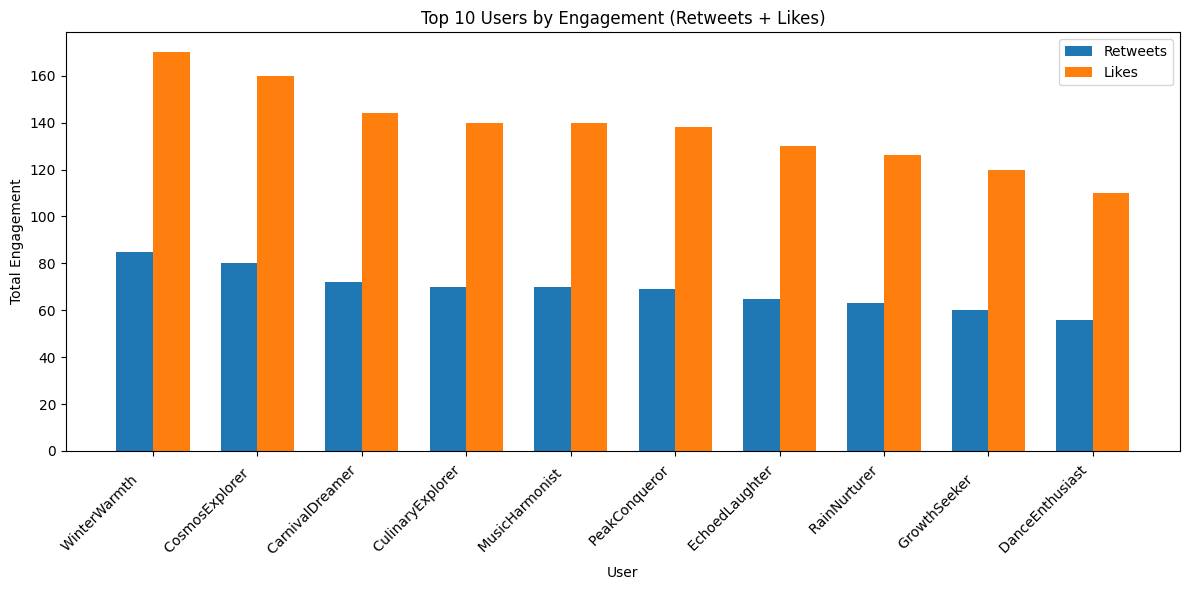

In [94]:
# User Engagement Analysis
top_users = df.groupby('User')[['Retweets', 'Likes']].sum().sort_values(by=['Retweets', 'Likes'], ascending=False).head(10)
print("\nTop Users by Engagement:\n", top_users)

# Visualization: Top Users by Engagement
plt.figure(figsize=(12, 6))
# Set the width of the bars
bar_width = 0.35
# Get the positions of the x ticks (users)
x_pos = np.arange(len(top_users.index))
# Create the bars for Retweets
plt.bar(x_pos, top_users['Retweets'], width=bar_width, label='Retweets')
# Create the bars for Likes, shifting them slightly to the right
plt.bar(x_pos + bar_width, top_users['Likes'], width=bar_width, label='Likes')


plt.title('Top 10 Users by Engagement (Retweets + Likes)')
plt.xlabel('User')
plt.ylabel('Total Engagement')
# Set the x-axis tick positions and labels
plt.xticks(x_pos + bar_width / 2, top_users.index, rotation=45, ha='right')
# Add a legend
plt.legend()
# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()

# 10. Advanced Analysis - Time-based Patterns


Average Sentiment by Hour:
 Timestamp
0     0.000000
2    -0.333333
3    -0.300000
5     1.000000
6     0.250000
7     0.159091
8     0.090459
9    -0.022362
10    0.158543
11    0.066409
12    0.118215
13    0.069808
14    0.061454
15    0.088419
16    0.063266
17    0.076117
18    0.094402
19    0.154298
20    0.211094
21    0.035105
22    0.123906
23   -0.043506
Name: Sentiment_Score, dtype: float64


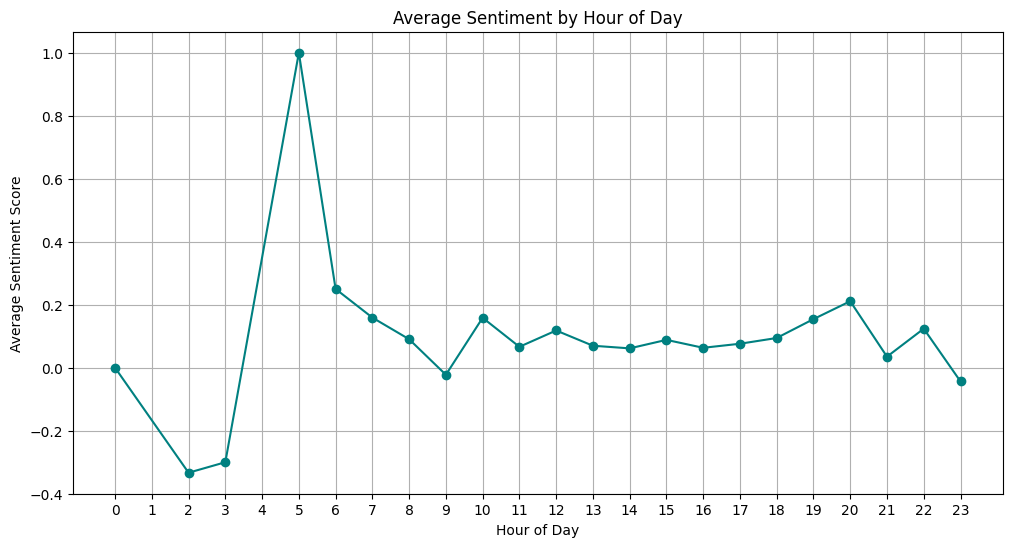

In [95]:
# Time-based Patterns
hourly_sentiment = df.groupby(df.index.hour)['Sentiment_Score'].mean()
print("\nAverage Sentiment by Hour:\n", hourly_sentiment)

# Visualization: Time-based Patterns
plt.figure(figsize=(12, 6))
hourly_sentiment.plot(kind='line', marker='o', linestyle='-', color='teal')
plt.title('Average Sentiment by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Sentiment Score')
plt.xticks(range(24))  # Set x-axis ticks to represent each hour of the day
plt.grid(True)
plt.show()

# 11. Advanced Analysis - Platform Comparison


Platform Performance Comparison:
             total_posts  avg_likes  avg_retweets  avg_sentiment
Platform                                                       
Instagram           258  45.089147     22.600775       0.107448
Facebook            231  41.870130     20.969697       0.082204
Twitter             128  45.382812     22.796875       0.123020
Twitter             115  37.304348     18.704348       0.053177


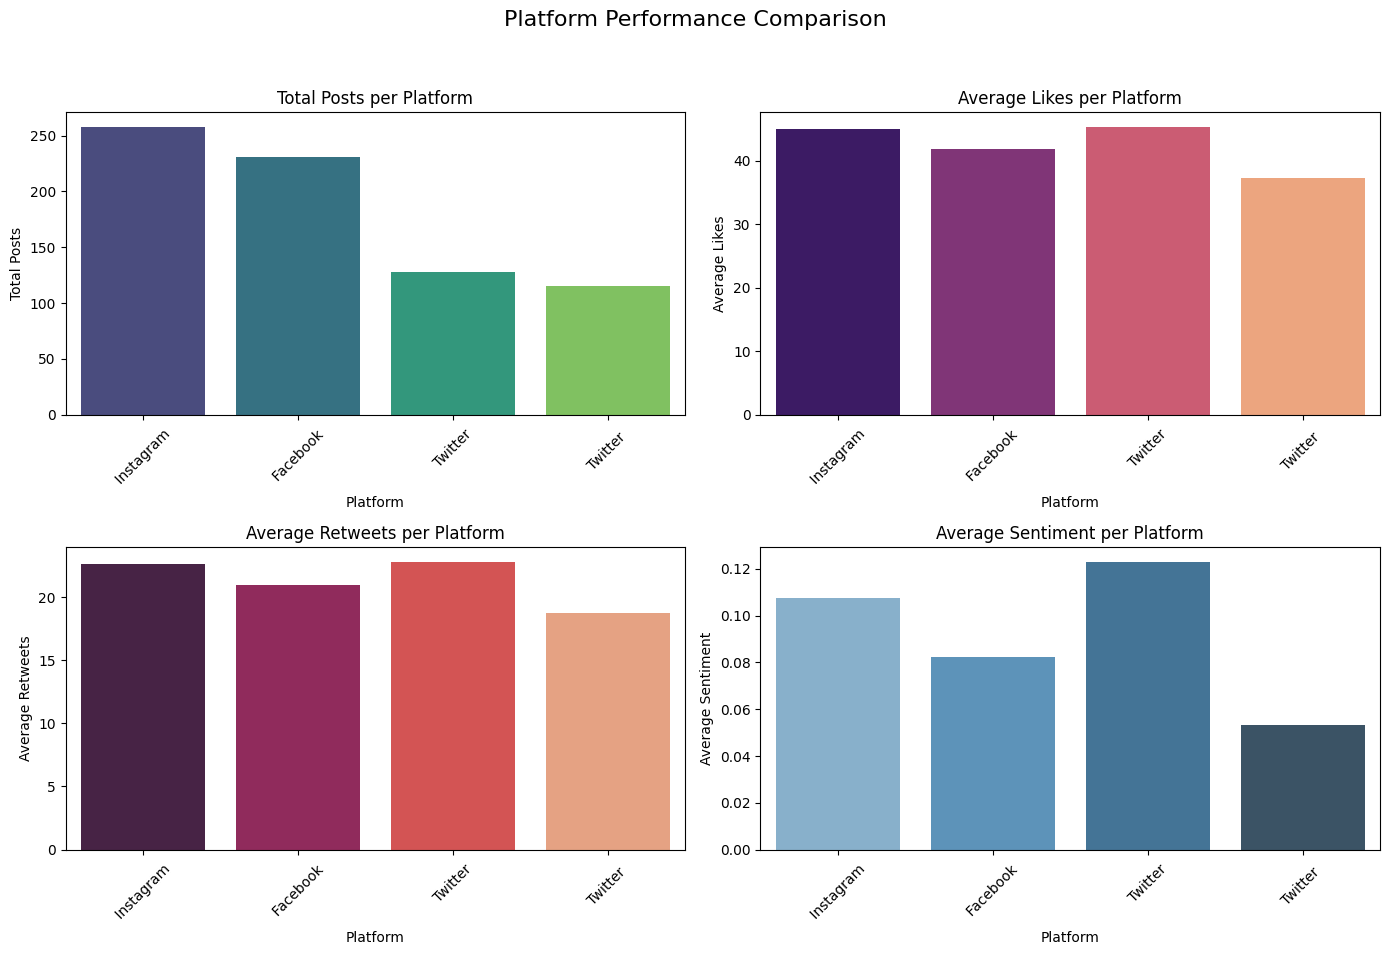

In [96]:
# Comparative Platform Analysis
platform_metrics = df.groupby('Platform').agg(
    total_posts=('Platform', 'size'),
    avg_likes=('Likes', 'mean'),
    avg_retweets=('Retweets', 'mean'),
    avg_sentiment=('Sentiment_Score', 'mean')
).sort_values(by='total_posts', ascending=False)
print("\nPlatform Performance Comparison:\n", platform_metrics)

# Visualization: Comparative Platform Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots
fig.suptitle('Platform Performance Comparison', fontsize=16)  # Set overall title

# Plot Total Posts
sns.barplot(x=platform_metrics.index, y=platform_metrics['total_posts'], ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Total Posts per Platform')
axes[0, 0].set_ylabel('Total Posts')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot Average Likes
sns.barplot(x=platform_metrics.index, y=platform_metrics['avg_likes'], ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Average Likes per Platform')
axes[0, 1].set_ylabel('Average Likes')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot Average Retweets
sns.barplot(x=platform_metrics.index, y=platform_metrics['avg_retweets'], ax=axes[1, 0], palette='rocket')
axes[1, 0].set_title('Average Retweets per Platform')
axes[1, 0].set_ylabel('Average Retweets')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot Average Sentiment
sns.barplot(x=platform_metrics.index, y=platform_metrics['avg_sentiment'], ax=axes[1, 1], palette='Blues_d')
axes[1, 1].set_title('Average Sentiment per Platform')
axes[1, 1].set_ylabel('Average Sentiment')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for better spacing
plt.show()

# 12. Advanced Analysis - Emotion Detection


Emotion Distribution:
 Emotion
neutral      642
happy         51
sad           19
surprised     13
fearful        6
angry          1
Name: count, dtype: int64


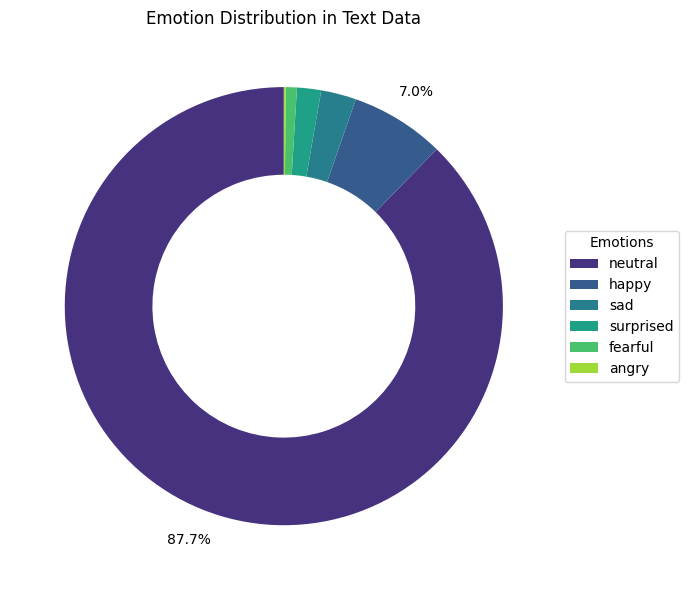

In [98]:
# Emotion Detection
emotion_lexicon = {
    'happy': ['joy', 'love', 'excitement', 'gratitude', 'contentment'],
    'sad': ['sadness', 'grief', 'melancholy', 'loneliness', 'despair'],
    'angry': ['anger', 'frustration', 'resentment', 'bitterness', 'indignation'],
    'surprised': ['surprise', 'astonishment', 'amazement', 'wonder', 'awe'],
    'fearful': ['fear', 'anxiety', 'dread', 'apprehension', 'terror']
}

def detect_emotion(text):
    emotion_counts = {emotion: 0 for emotion in emotion_lexicon}
    words = text.split()
    for word in words:
        for emotion, keywords in emotion_lexicon.items():
            if word in keywords:
                emotion_counts[emotion] += 1
    if not any(emotion_counts.values()):
        return 'neutral'
    return max(emotion_counts, key=emotion_counts.get)

df['Emotion'] = df['Processed_Text'].apply(detect_emotion)

emotion_distribution = df['Emotion'].value_counts()
print("\nEmotion Distribution:\n", emotion_distribution)


# Visualization: Emotion Distribution
plt.figure(figsize=(10, 6))
# Create the pie chart (which will be a donut chart)
wedges, texts, autotexts = plt.pie(emotion_distribution,
                                  autopct=lambda pct: f'{pct:.1f}%' if pct > 3 else '', # Show percentages only if > 3%
                                  startangle=90,
                                  colors=sns.color_palette("viridis", len(emotion_distribution)),
                                  pctdistance=1.15, # Move percentages outward
                                  wedgeprops=dict(width=0.4)) # Create the hole for the donut
# Add a legend outside the chart for labels
plt.legend(wedges, emotion_distribution.index,
          title="Emotions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Emotion Distribution in Text Data')
plt.tight_layout()
plt.show()

# 13. Additional Visualizations

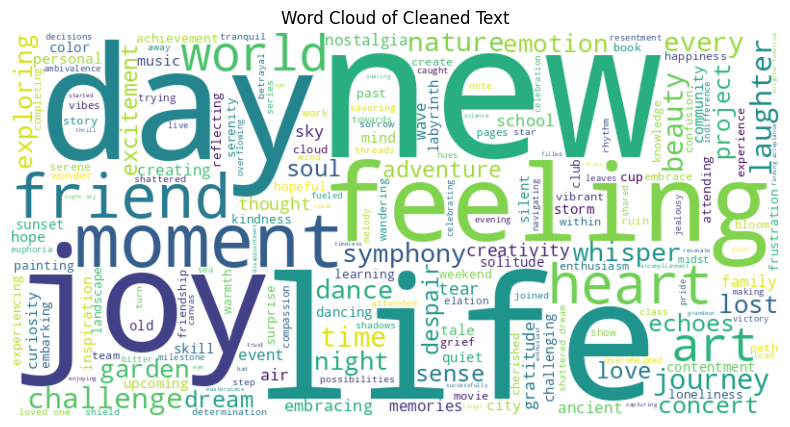

In [99]:
# Word Cloud Visualization
def generate_wordcloud(text, title="Word Cloud"):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_wordcloud(df['Cleaned_Text'], title="Word Cloud of Cleaned Text")

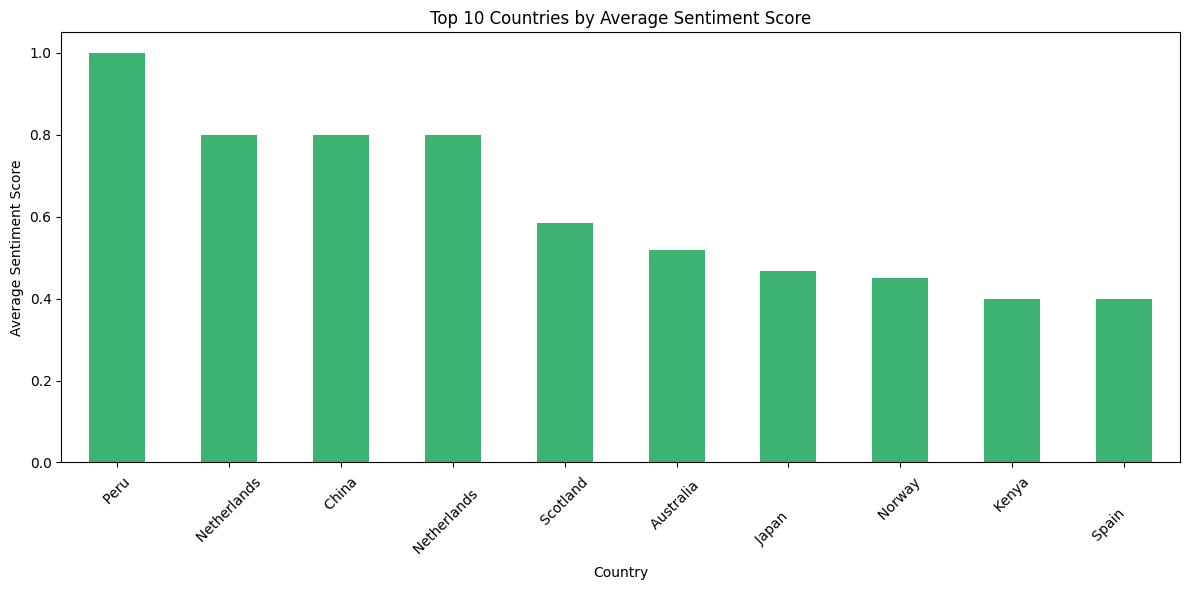

In [71]:
# Sentiment by Country Visualization
country_sentiment = df.groupby('Country')['Sentiment_Score'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
country_sentiment.head(10).plot(kind='bar', color='mediumseagreen')
plt.title('Top 10 Countries by Average Sentiment Score')
plt.xlabel('Country')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

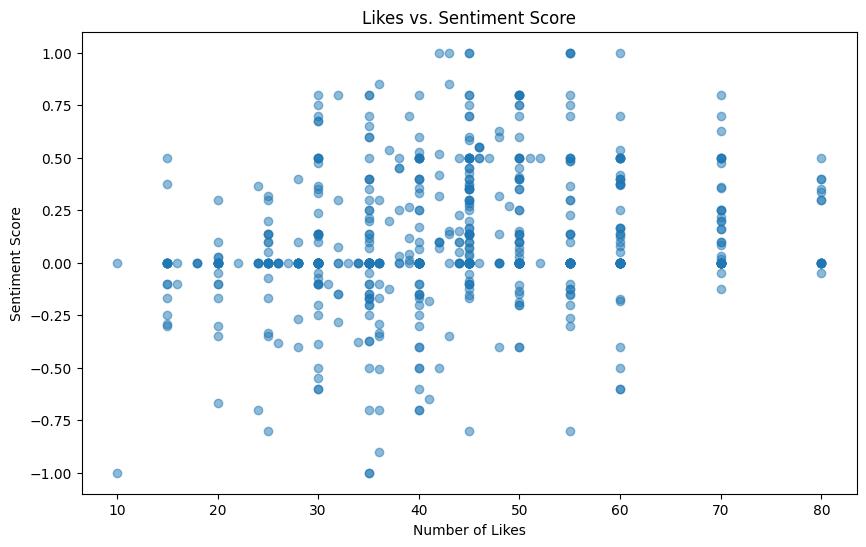

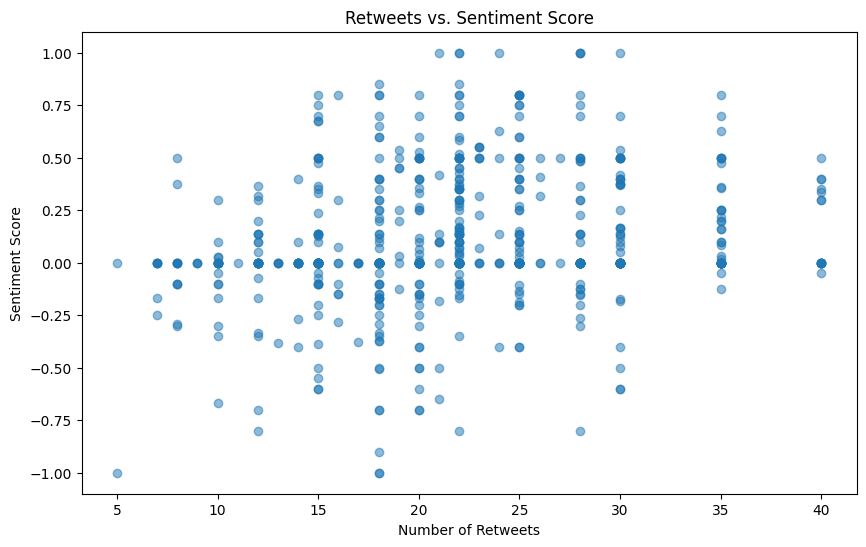

In [100]:
# Engagement vs Sentiment Visualizations
plt.figure(figsize=(10,6))
plt.scatter(df['Likes'], df['Sentiment_Score'], alpha=0.5)
plt.title('Likes vs. Sentiment Score')
plt.xlabel('Number of Likes')
plt.ylabel('Sentiment Score')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(df['Retweets'], df['Sentiment_Score'], alpha=0.5)
plt.title('Retweets vs. Sentiment Score')
plt.xlabel('Number of Retweets')
plt.ylabel('Sentiment Score')
plt.show()

<Figure size 1000x800 with 0 Axes>

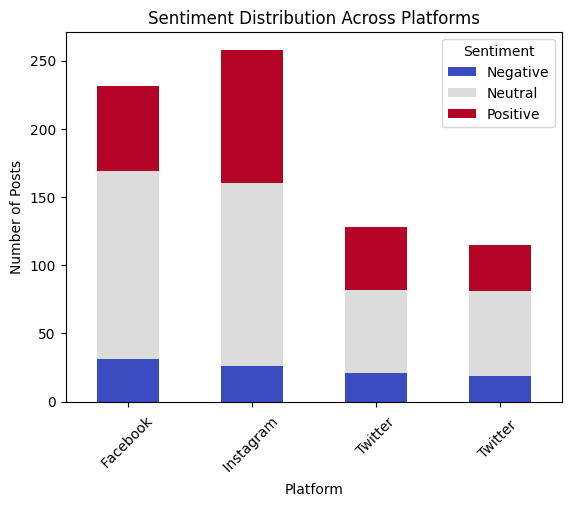

In [101]:
# Sentiment Distribution Across Platforms Visualization
plt.figure(figsize=(10, 8))
platform_sentiment_distribution.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Sentiment Distribution Across Platforms')
plt.xlabel('Platform')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

# 14. Summary of Findings

In [103]:
# Summary of Findings
print("\n--- Summary of Findings ---")

print("\nOverall Sentiment Distribution:")
print(df['Calculated_Sentiment'].value_counts())

print("\nAverage Sentiment Score by Platform (Higher is more positive):")
print(platform_sentiment)

print("\nTop 20 Trending Hashtags:")
print(top_20_hashtags)

print("\nSentiment Distribution across Platforms:")
print(platform_sentiment_distribution)

print("\nMonthly Average Sentiment (showing trends over time):")
print(monthly_sentiment)

print("\nTop Users by Engagement:")
print(top_users)

print("\nEmotion Distribution:")
print(emotion_distribution)

print("\nAnalysis Complete.")


--- Summary of Findings ---

Overall Sentiment Distribution:
Calculated_Sentiment
Neutral     395
Positive    240
Negative     97
Name: count, dtype: int64

Average Sentiment Score by Platform (Higher is more positive):
Platform
Twitter       0.123020
Instagram     0.107448
Facebook      0.082204
Twitter       0.053177
Name: Sentiment_Score, dtype: float64

Top 20 Trending Hashtags:
[('#Serenity', 15), ('#Gratitude', 13), ('#Excitement', 13), ('#Despair', 11), ('#Nostalgia', 11), ('#Contentment', 10), ('#Curiosity', 10), ('#Awe', 9), ('#Grief', 9), ('#Loneliness', 9), ('#Hopeful', 9), ('#Enthusiasm', 8), ('#Joy', 8), ('#Acceptance', 8), ('#Confusion', 8), ('#Inspiration', 7), ('#Elation', 7), ('#Euphoria', 7), ('#Determination', 7), ('#Reflection', 6)]

Sentiment Distribution across Platforms:
Calculated_Sentiment  Negative  Neutral  Positive
Platform                                         
Facebook                    31      138        62
Instagram                   26      134     

In [104]:
df.to_csv('processed_data.csv', index=False)